<a href="https://colab.research.google.com/github/Khaimin6/CTF_solution/blob/main/11_Buzzing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q11 Buzzing - Here's a strange bmp image

- This is only partial solution, still figuring out

In [1]:
!sudo apt install libimage-exiftool-perl


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
Suggested packages:
  libposix-strptime-perl libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
0 upgraded, 5 newly installed, 0 to remove and 1 not upgraded.
Need to get 3,964 kB of archives.
After this operation, 23.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-zip-perl all 1.68-1 [90.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libimage-exiftool-perl all 12.40+dfsg-1 [3,717 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmime-charset-perl all 1.012.2-1 [30.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/univer

In [2]:
# download image
!wget https://ctf.hackme.quest/static/buzzing.txz
!xz -d buzzing.txz
!tar -xf buzzing.tar

--2025-12-30 04:34:01--  https://ctf.hackme.quest/static/buzzing.txz
Resolving ctf.hackme.quest (ctf.hackme.quest)... 114.44.200.99
Connecting to ctf.hackme.quest (ctf.hackme.quest)|114.44.200.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79224 (77K) [application/octet-stream]
Saving to: ‘buzzing.txz’

buzzing.txz         100%[===================>]  77.37K   362KB/s    in 0.2s    

2025-12-30 04:34:02 (362 KB/s) - ‘buzzing.txz’ saved [79224/79224]



In [3]:
!ls

buzzing.bmp  buzzing.tar  sample_data


In [4]:
!exiftool -h

Syntax:  exiftool [OPTIONS] FILE

Consult the exiftool documentation for a full list of options.


In [5]:
!exiftool buzzing.bmp

ExifTool Version Number         : 12.40
File Name                       : buzzing.bmp
Directory                       : .
File Size                       : 1000 KiB
File Modification Date/Time     : 2017:03:09 06:21:07+00:00
File Access Date/Time           : 2025:12:30 04:34:02+00:00
File Inode Change Date/Time     : 2025:12:30 04:34:02+00:00
File Permissions                : -rw-r--r--
File Type                       : BMP
File Type Extension             : bmp
MIME Type                       : image/bmp
BMP Version                     : Windows V5
Image Width                     : 371
Image Height                    : 377
Planes                          : 1
Bit Depth                       : 32
Compression                     : Bitfields
Image Length                    : 1024000
Pixels Per Meter X              : 2835
Pixels Per Meter Y              : 2835
Num Colors                      : Use BitDepth
Num Important Colors            : All
Red Mask                        : 0x41000000
Gr

In [6]:
hex(2122219010)

'0x7e7e7e02'

## Analyse Hex
- `BMP Version: Windows V5`
- https://en.wikipedia.org/wiki/BMP_file_format
- https://learn.microsoft.com/en-us/windows/win32/api/wingdi/ns-wingdi-bitmapv5header

In [43]:
!hexdump -C buzzing.bmp | head -n 50

00000000  42 4d 8a a0 0f 00 00 00  00 00 8a 00 00 00 7c 00  |BM............|.|
00000010  00 00 73 01 00 00 79 01  00 00 01 00 20 00 03 00  |..s...y..... ...|
00000020  00 00 00 a0 0f 00 13 0b  00 00 13 0b 00 00 00 00  |................|
00000030  00 00 00 00 00 00 00 00  00 41 00 00 41 00 00 41  |.........A..A..A|
00000040  00 00 41 00 00 00 42 47  52 73 00 00 00 00 00 00  |..A...BGRs......|
00000050  00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  |................|
*
00000070  7e 7e 7e 7e 7e 7e 7e 7e  7e 7e 02 7e 7e 7e 7e 7e  |~~~~~~~~~~.~~~~~|
00000080  7e 7e 7e 7e 7e 7e 7e 7e  7e 7e 41 41 41 41 41 41  |~~~~~~~~~~AAAAAA|
00000090  41 41 41 41 41 41 41 41  41 41 41 41 41 41 41 41  |AAAAAAAAAAAAAAAA|
*
00003310  41 41 41 ca ca ca 41 1d  1d 1d 41 f9 f9 f9 41 41  |AAA...A...A...AA|
00003320  41 41 41 41 41 41 41 41  41 41 41 41 41 41 41 41  |AAAAAAAAAAAAAAAA|
*
00003720  41 41 41 41 41 41 41 79  79 79 41 04 04 04 41 10  |AAAAAAAyyyA...A.|
00003730  10 10 41 f9 f9 f9 41 41  41 41 41 41

- showing repeated rows of `AAAA`(`0x41414141`) in data
- RGBA data, all Alpha channel == `0x41`, so currently ignored

In [8]:
import struct

def read_bmp_header(filename):
    with open(filename, 'rb') as f:

        signature = f.read(2)
        if signature != b'BM':
            raise ValueError("Not a BMP file")

        file_size_0x02 , _reserved_0x06, data_offset_0x0A, DiB_0x0E= struct.unpack('<4I', f.read(16)) # Little-endian unsigned int

        f.seek(0x12)
        width_0x12 = struct.unpack('<I', f.read(4))[0]
        height_0x16 = struct.unpack('<I', f.read(4))[0]

        _color_plane_1E, _bit_per_pixel, _mode, _data_size = struct.unpack('<2H2I', f.read(12))

        # ... read other headers, then seek to data_offset and read pixel bytes
        # f.seek(data_offset)

        # pixel_data = []
        # while s := f.read(4):
        #     if s != b'AAAA':
        #         pixel_data.append(s)

        return locals()


In [9]:
ss = read_bmp_header("buzzing.bmp")

In [10]:
ss

{'filename': 'buzzing.bmp',
 'f': <_io.BufferedReader name='buzzing.bmp'>,
 'signature': b'BM',
 'file_size_0x02': 1024138,
 '_reserved_0x06': 0,
 'data_offset_0x0A': 138,
 'DiB_0x0E': 124,
 'width_0x12': 371,
 'height_0x16': 377,
 '_color_plane_1E': 1,
 '_bit_per_pixel': 32,
 '_mode': 3,
 '_data_size': 1024000}

In [122]:
import struct

def parse_bmp_header(filename):
    with open(filename, 'rb') as f:

        signature = f.read(2)
        if signature != b'BM':
            raise ValueError("Not a BMP file")

        info_names = ["File size", "_reserved", "Data Offset",
                     #DiB Section
                     "DiB Size", "Width", "Height"
                     ]

        for i in info_names:
            offset = f.tell()
            data = struct.unpack('<I', f.read(4)) # Little-endian unsigned int
            print("%15s (%2i| 0x%02X) =" % (i, offset, offset) , data)


        f.seek(34)
        temp_list = ["Image size", "h resolution", "v resolution"]

        for i in temp_list:
            offset = f.tell()
            data = struct.unpack('<I', f.read(4))
            print("%15s (%2i| 0x%02X) =" % (i, offset, offset), data)


        f.seek(0x36)
        offset = f.tell()
        print("\n%s (%2i| 0x%02X)" % ("Masks RGBA", offset, offset))

        for i in struct.unpack('<LLLL', f.read(16)):
            print("- 0x%08x" % i)

        offset = f.tell()
        print("\n%s (%2i| 0x%02X)" % ("LogicalColorSpace", offset, offset))

        data = struct.unpack('<4s', f.read(4))[0]
        print("-", data[::-1])



In [123]:
parse_bmp_header("buzzing.bmp")

      File size ( 2| 0x02) = (1024138,)
      _reserved ( 6| 0x06) = (0,)
    Data Offset (10| 0x0A) = (138,)
       DiB Size (14| 0x0E) = (124,)
          Width (18| 0x12) = (371,)
         Height (22| 0x16) = (377,)
     Image size (34| 0x22) = (1024000,)
   h resolution (38| 0x26) = (2835,)
   v resolution (42| 0x2A) = (2835,)

Masks RGBA (54| 0x36)
- 0x41000000
- 0x00410000
- 0x00004100
- 0x00000041

LogicalColorSpace (70| 0x46)
- b'sRGB'


## Resize Image
- recommend to use https://hexed.it in editing bytes

In [13]:
371 * 377 * 4, 1024000

(559468, 1024000)

- the image does not show full content
- try `(1000, 256)` to show full image (1000 * 256 * 4 == 1024000)

In [236]:
import struct

{
    0x12: struct.pack("<2I", 1000,256),
    0x36: struct.pack("<4L", 0xFF000000, 0x00FF0000, 0x0000FF00, 0x000000FF)
}

{18: b'\xe8\x03\x00\x00\x00\x01\x00\x00',
 54: b'\x00\x00\x00\xff\x00\x00\xff\x00\x00\xff\x00\x00\xff\x00\x00\x00'}

In [200]:
#1.copy image
#2.resize image
#3.change mask from \x41 to \xFF
#4.change Color Space to calibrated RGB

!cp buzzing.bmp buzzing_1000x256.bmp
!printf '\xe8\x03\x00\x00\x00\x01\x00\x00' | dd of=buzzing_1000x256.bmp bs=1 seek=18 conv=notrunc
!printf '\x00\x00\x00\xff\x00\x00\xff\x00\x00\xff\x00\x00\xff\x00\x00\x00' | dd of=buzzing_1000x256.bmp bs=1 seek=54 conv=notrunc
# !printf '\x00\x00\x00\x00' | dd of=buzzing_1000x256.bmp bs=1 seek=70 conv=notrunc

8+0 records in
8+0 records out
8 bytes copied, 0.00010415 s, 76.8 kB/s
16+0 records in
16+0 records out
16 bytes copied, 0.000115858 s, 138 kB/s
4+0 records in
4+0 records out
4 bytes copied, 0.00158718 s, 2.5 kB/s


In [201]:
# ensure correct result
!exiftool buzzing_1000x256.bmp

ExifTool Version Number         : 12.40
File Name                       : buzzing_1000x256.bmp
Directory                       : .
File Size                       : 1000 KiB
File Modification Date/Time     : 2025:12:30 07:06:23+00:00
File Access Date/Time           : 2025:12:30 06:55:22+00:00
File Inode Change Date/Time     : 2025:12:30 07:06:23+00:00
File Permissions                : -rw-r--r--
File Type                       : BMP
File Type Extension             : bmp
MIME Type                       : image/bmp
BMP Version                     : Windows V5
Image Width                     : 1000
Image Height                    : 256
Planes                          : 1
Bit Depth                       : 32
Compression                     : Bitfields
Image Length                    : 1024000
Pixels Per Meter X              : 2835
Pixels Per Meter Y              : 2835
Num Colors                      : Use BitDepth
Num Important Colors            : All
Red Mask                        : 0xf

In [202]:
struct.pack("<2I", 32382, 49411)

b'~~\x00\x00\x03\xc1\x00\x00'

## Process Image, and capture the flag

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 #pip install opencv-python
from PIL import Image #pip install pillow

img = cv2.imread("buzzing_1000x256.bmp")

array([[[65, 65, 65],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       [[65, 65, 65],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       [[65, 65, 65],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       ...,

       [[65, 65, 65],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       [[65, 65, 65],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       [[65, 65, 65],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]]], dtype=uint8)
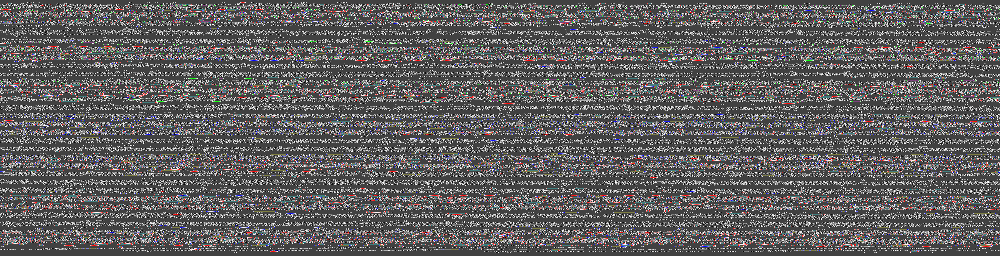

In [232]:
img

In [233]:
img = img.reshape(512,500,3)

a = img[:, :, 0] ^ img[:, :, 1]
b = img[:, :, 1] ^ img[:, :, 2]
c = img[:, :, 2] ^ img[:, :, 0]

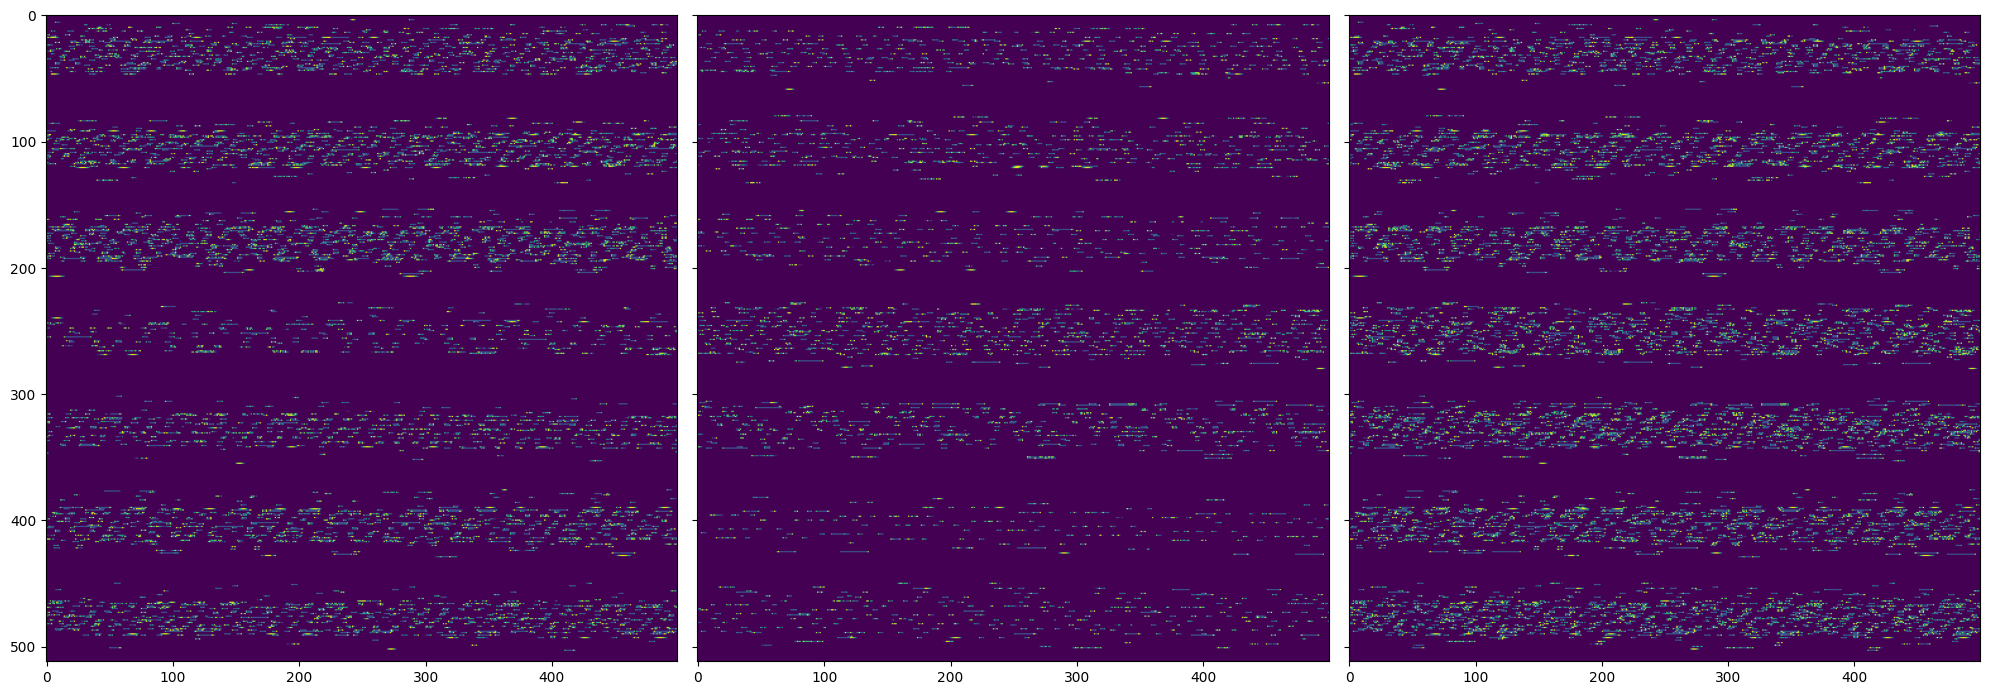

In [234]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,10))
ax1.imshow(a)
ax2.imshow(b)
ax3.imshow(c)

fig.tight_layout()

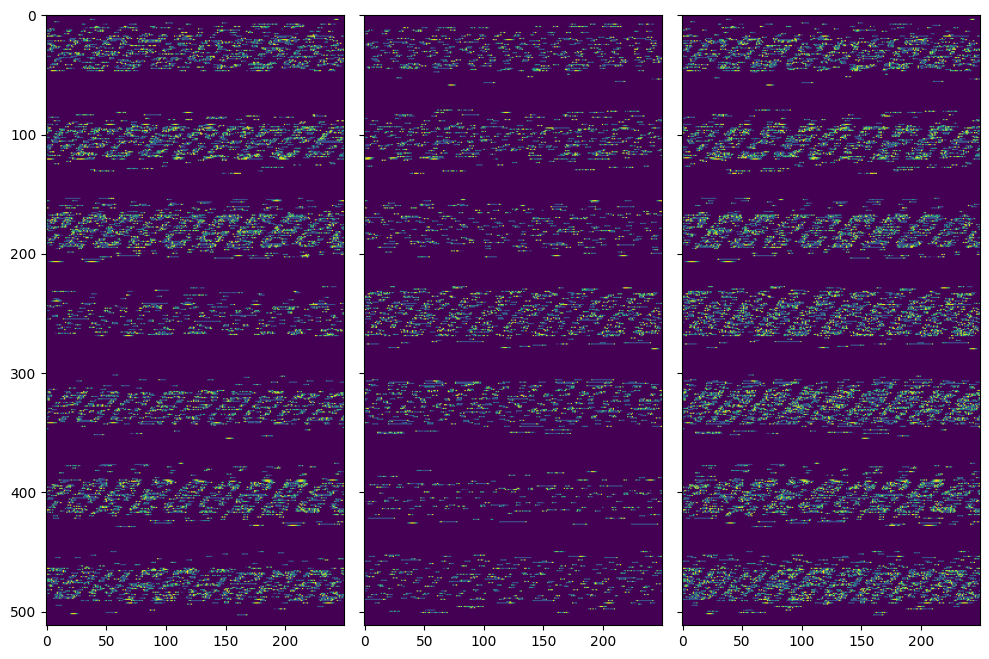

In [235]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,10))

a1 = a[:, :250] ^ a[:, 250:]
b1 = b[:, :250] ^ b[:, 250:]
c1 = c[:, :250] ^ c[:, 250:]

ax1.imshow(a1)
ax2.imshow(b1)
ax3.imshow(c1)

fig.tight_layout()

array([[65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65],
       ...,
       [65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65],
       [65, 65, 65, ..., 65, 65, 65]], dtype=uint8)
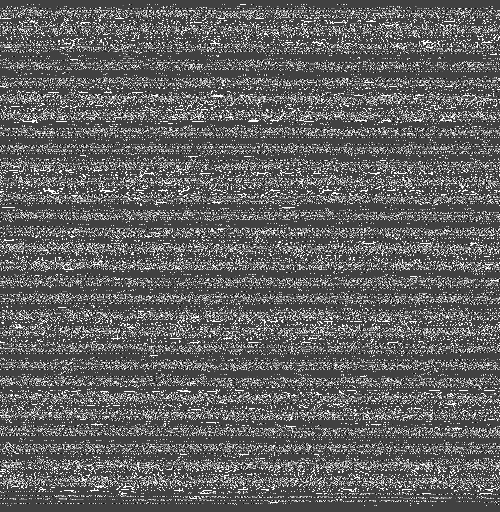

In [239]:
u = img[:, :, 0] ^ img[:, :, 1] ^ img[:, :, 2]
u

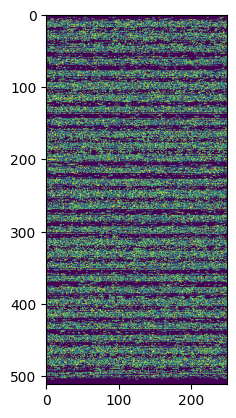

In [242]:
u1 = u[:, :250] ^ u[:, 250:]
plt.imshow(u1)

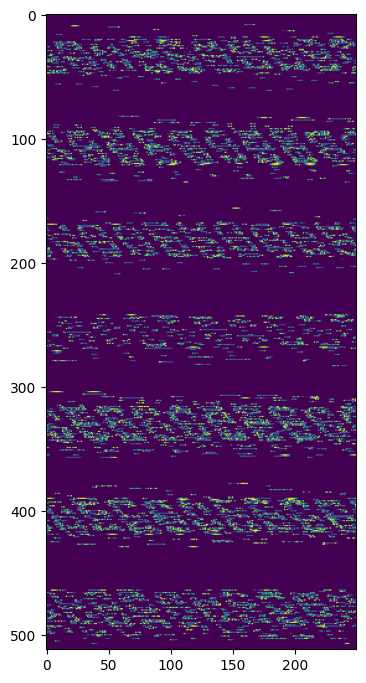

In [250]:
plt.figure(figsize=plt.figaspect(3))
plt.imshow(a1[::-1, :]);